# 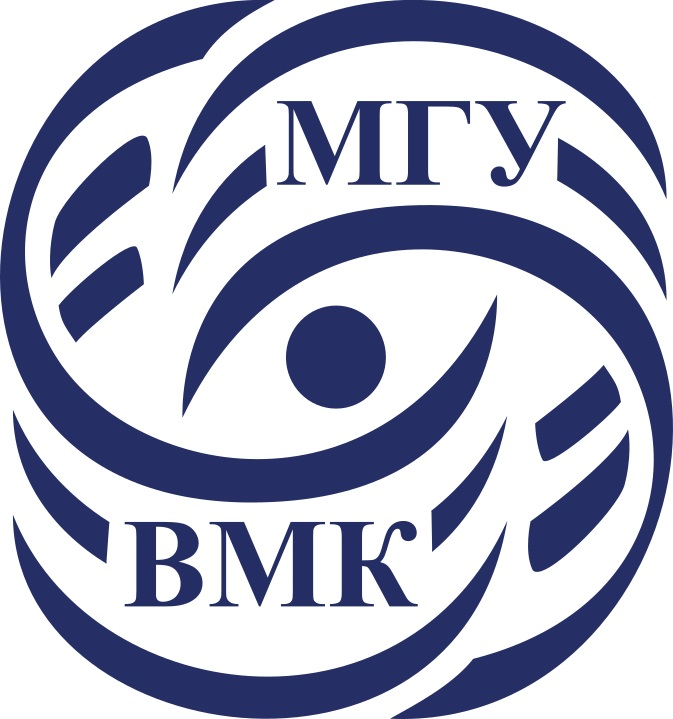

# Машинное обучение. ВМК МГУ

# Практическое задание 7: SVM
## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

Цель данного задания:

* Изучите работу модели SVM
* Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
* Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)

-------
<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: до 10 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [3]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r requirements_2024_25_for_colab_small.txt

Downloading...
From: https://drive.google.com/uc?id=10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
To: c:\Users\user\3_cours\ML_3_cours\8_hometask\requirements_2024_25_for_colab_small.txt

  0%|          | 0.00/375 [00:00<?, ?B/s]
100%|██████████| 375/375 [00:00<00:00, 375kB/s]


Проверим версию библиотеки:

In [7]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

Приведем вспомогательный код

In [9]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [10]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()

def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(loc=1.0, size=(size1, 2)),
        np.random.normal(loc=0.5, size=(size2, 2))
    )]

    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [11]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# Загрузка данных

In [12]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1bp39_Jj0edo1lzxZ3DIoChsOVy5DVi1R?usp=sharing')

Retrieving folder contents


Retrieving folder 1tv605hGxdQtd4zC787DbcRF0312gDeK_ imbalanced
Processing file 14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u X_imb_test.npz.npy
Processing file 1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc X_imb.npz.npy
Processing file 1uD87Xbh4MMBBn5fsScrknI54SINIqory y_imb_test.npz.npy
Processing file 1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf y_imb.npz.npy
Retrieving folder 1uoI6vZWwIII1jd2k5TtsZTJ3JOkK0G6O public
Processing file 1Win7ZtHLHEbDtX6x6O7vBJHwJviQxbp5 cX_test.npy
Processing file 1MowPnLFAMEjjcAjDA4skE4OUFdmaiSY6 cX_train.npy
Processing file 1VYA4N5wCQhwteQSZkDogFTha2xRv0FgW cy_train.npy


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u
To: c:\Users\user\3_cours\ML_3_cours\8_hometask\05-SVM\imbalanced\X_imb_test.npz.npy
100%|██████████| 2.05k/2.05k [00:00<?, ?B/s]
Downloading...
From: https://drive.google.com/uc?id=1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc
To: c:\Users\user\3_cours\ML_3_cours\8_hometask\05-SVM\imbalanced\X_imb.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 2.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uD87Xbh4MMBBn5fsScrknI54SINIqory
To: c:\Users\user\3_cours\ML_3_cours\8_hometask\05-SVM\imbalanced\y_imb_test.npz.npy
100%|██████████| 1.09k/1.09k [00:00<?, ?B/s]
Downloading...
From: https://drive.google.com/uc?id=1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf
To: c:\Users\user\3_cours\ML_3_cours\8_hometask\05-SVM\imbalanced\y_imb.npz.npy
100%|██████████| 1.09k/1.09k [00:00<?, ?B/s]
Downloading...
From: https://driv

['c:\\Users\\user\\3_cours\\ML_3_cours\\8_hometask\\05-SVM\\imbalanced\\X_imb_test.npz.npy',
 'c:\\Users\\user\\3_cours\\ML_3_cours\\8_hometask\\05-SVM\\imbalanced\\X_imb.npz.npy',
 'c:\\Users\\user\\3_cours\\ML_3_cours\\8_hometask\\05-SVM\\imbalanced\\y_imb_test.npz.npy',
 'c:\\Users\\user\\3_cours\\ML_3_cours\\8_hometask\\05-SVM\\imbalanced\\y_imb.npz.npy',
 'c:\\Users\\user\\3_cours\\ML_3_cours\\8_hometask\\05-SVM\\public\\cX_test.npy',
 'c:\\Users\\user\\3_cours\\ML_3_cours\\8_hometask\\05-SVM\\public\\cX_train.npy',
 'c:\\Users\\user\\3_cours\\ML_3_cours\\8_hometask\\05-SVM\\public\\cy_train.npy']

# SVM и разделяющая поверхность

На лекции вы изучили, что линейная, с виду, модель SVM, при помощи некоторых "фокусов", называемых ядрами, умеет строить нелинейные поверхности. В данном ноутбуке посмотрим, как это все работает на практике, и какие гиперпараметры настройки у этого метода есть.

<font color='MediumTurquoise'>**Историческая справка:**</font> Метод опорных векторов (SVM) стал популярным в 90-х годах, особенно с 1995 года, благодаря своей эффективности в задачах классификации и способности обрабатывать высокоразмерные данные. Он также привлек внимание благодаря использованию ядровых функций, что позволяло решать нелинейные задачи. Однако с появлением более сложных методов, таких как глубокое обучение, и увеличением объема данных, SVM стал менее популярным, поскольку более современные алгоритмы демонстрировали лучшие результаты на больших наборах данных и обеспечивали более простую настройку.

## <font color='DarkOrange'>**Задание 1 [1 балл]**</font>


В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.


    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью $\mbox{sklearn.svm.SVC(kernel='linear')}$, а также нелинейную c rbf-ядром с помощью $\mbox{sklearn.svm.SVC(kernel='rbf')}$. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [12]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

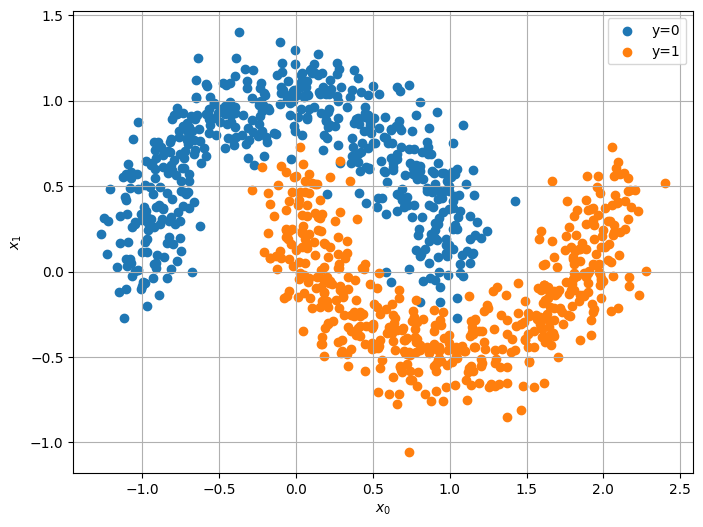

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

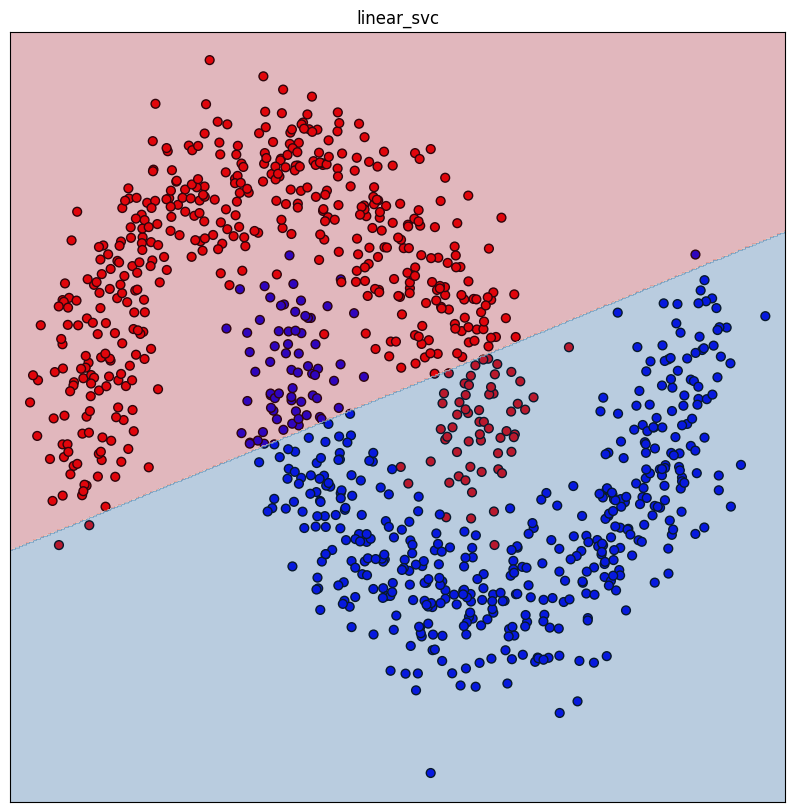

Train Accuracy (linear): 0.870


In [14]:
linear_svc.fit(X, y)
plot_separating_surface(X, y, linear_svc, title='linear_svc')
print(f'Train Accuracy (linear): {accuracy_score(y, linear_svc.predict(X)):.3f}')

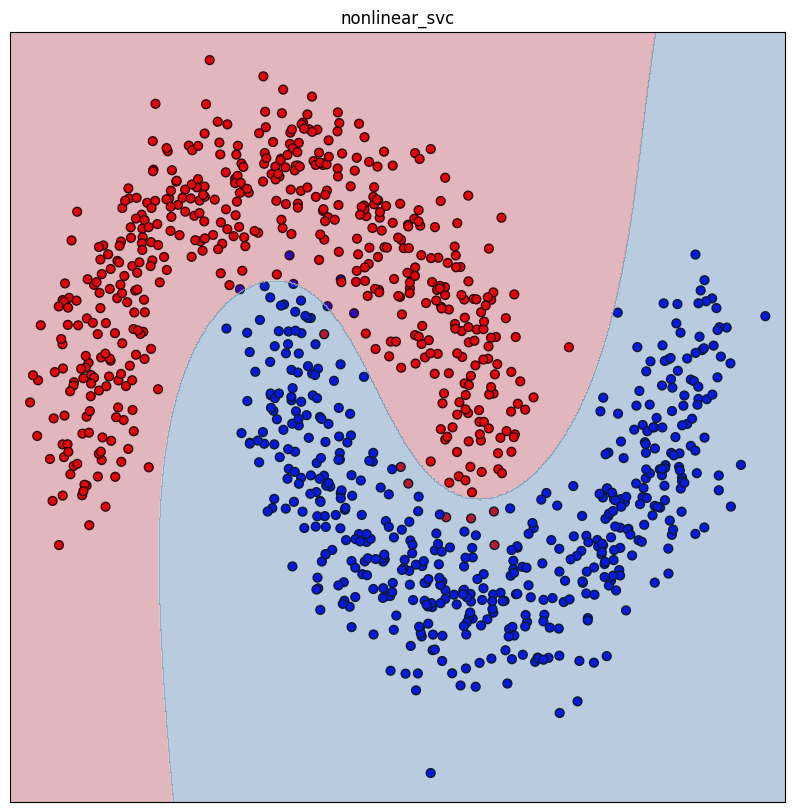

Train Accuracy (non linear): 0.988


In [15]:
nonlinear_svc.fit(X, y)
plot_separating_surface(X, y, nonlinear_svc, title='nonlinear_svc')
print(f'Train Accuracy (non linear): {accuracy_score(y, nonlinear_svc.predict(X)):.3f}')

**Сделайте вывод**
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему?

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Для данной задачи больше подходит модель с нелинейным ядром, поскольку выборка оказывается линейно неразделимой. 

Mодель с нелинейным ядром позволяет более эффективно захватывать сложные зависимости в данных, что в свою очередь способствует улучшению качества предсказаний и более точной классификации.

## 2. Опорные объекты

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достанем опорные объекты из обученной модели с помощью поля model.support_.

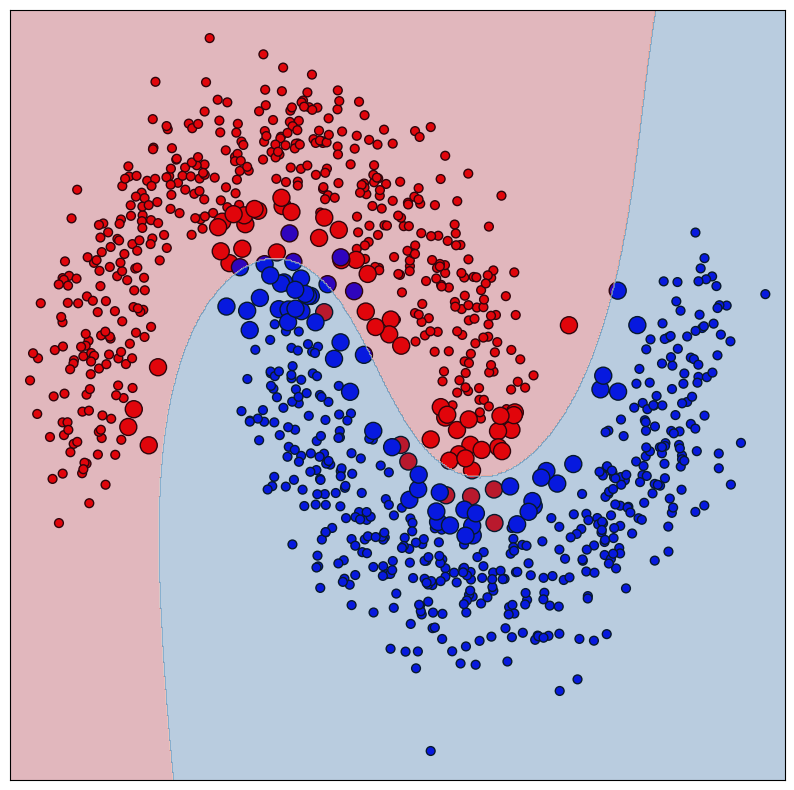

In [16]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

Обучим новые две модели $\mbox{SVC(kernel='rbf')}$, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [17]:
# Учим модели только на опорных объектах
svc_on_linear_support = SVC(kernel='rbf').fit(X[linear_svc.support_, :], y[linear_svc.support_])
svc_on_rbf_support = SVC(kernel='rbf').fit(X[nonlinear_svc.support_, :], y[nonlinear_svc.support_])

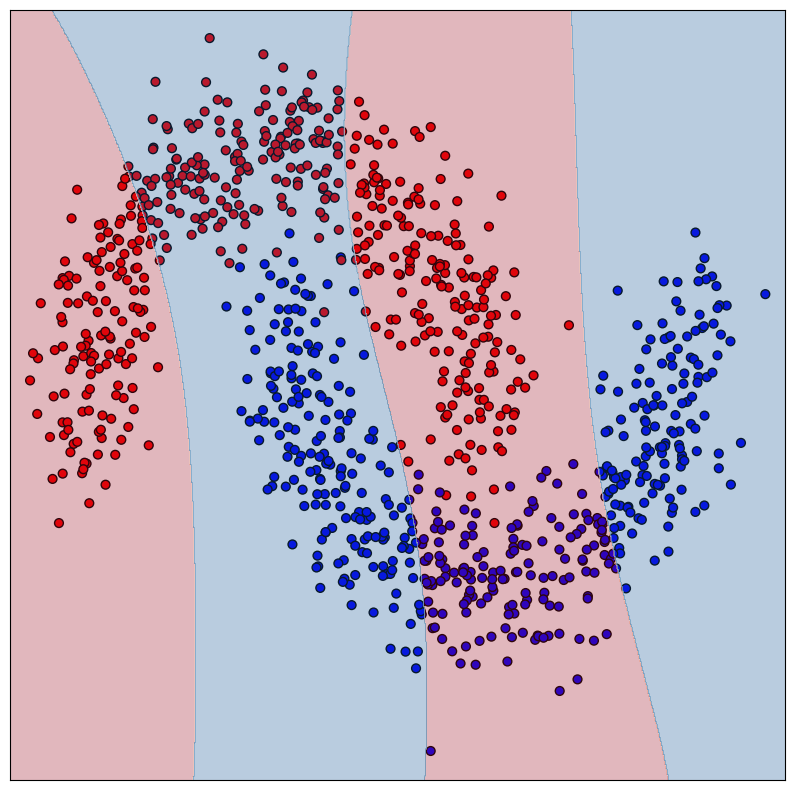

In [18]:
plot_separating_surface(X, y, svc_on_linear_support)

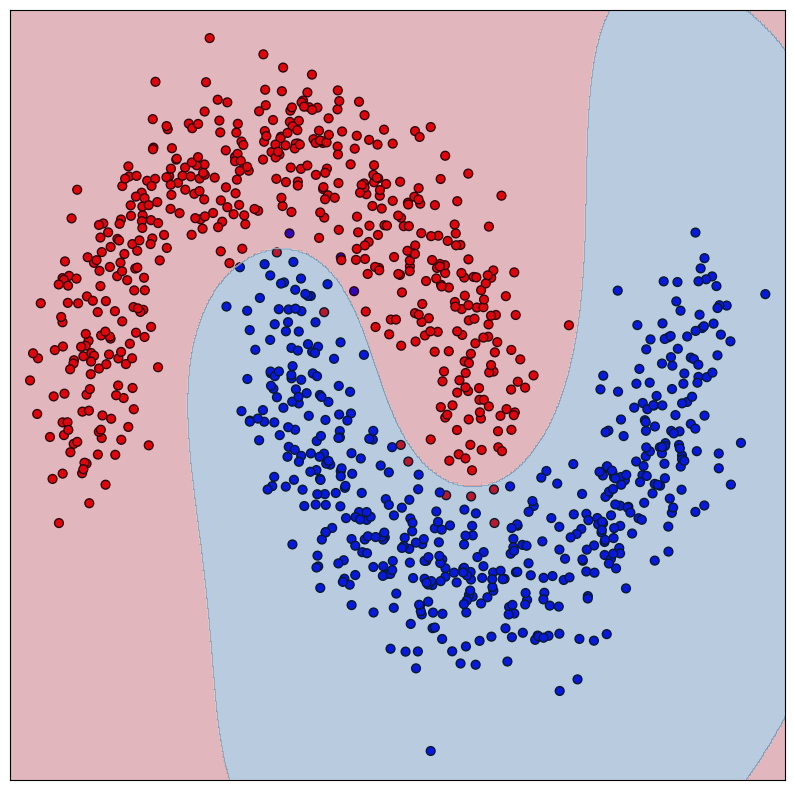

In [19]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 2 [1 балл]**</font>

Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из задания 1. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе.


<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Разделяющая поверхность, созданная на основе опорных объектов нелинейной модели напоминает нелинейную модель (nonlinear_svc) из задания 1, так как она лучше справляется с моделированием сложных границ между классами. Это свидетельствует о том, что применение опорных объектов из нелинейной модели приводит к более высоким результатам при использовании ядра RBF, поскольку они содержат более значимую информацию о структуре данных. Кроме того, использование нелинейных методов позволяет избежать переобучения, так как модель становится более адаптивной к различным паттернам в данных. В конечном итоге, это приводит к улучшению обобщающей способности модели и повышению её эффективности на новых, ранее не виденных данных.

---

Теперь обучим модель $\mbox{SVC(kernel='rbf')}$, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравним эту модель вместе с svc_on_rbf_support с нелинейной моделью из задания 1(nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [20]:
non_support_vectors = [i for i in range(len(X)) if i not in nonlinear_svc.support_]
svc_all_without_rbf_support = SVC(kernel='rbf').fit(X[non_support_vectors, :], y[non_support_vectors])

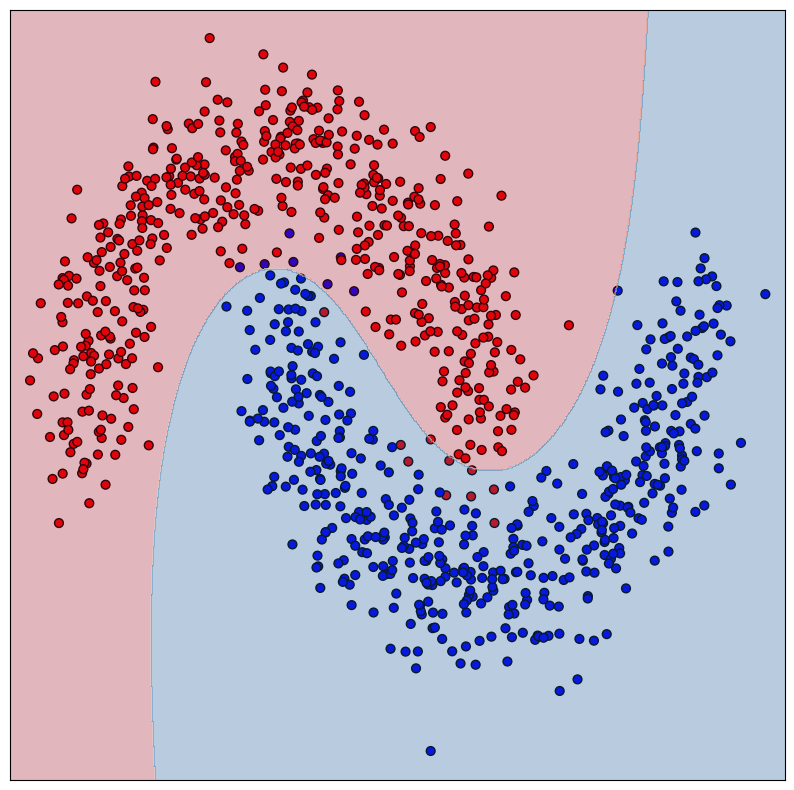

In [21]:
plot_separating_surface(X, y, svc_all_without_rbf_support)

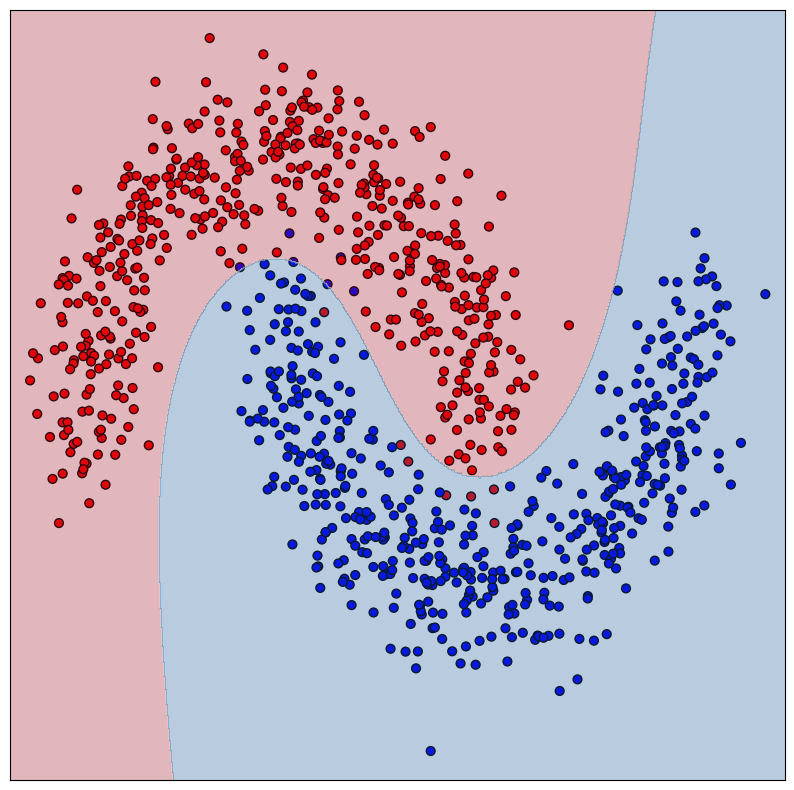

In [22]:
plot_separating_surface(X, y, nonlinear_svc)

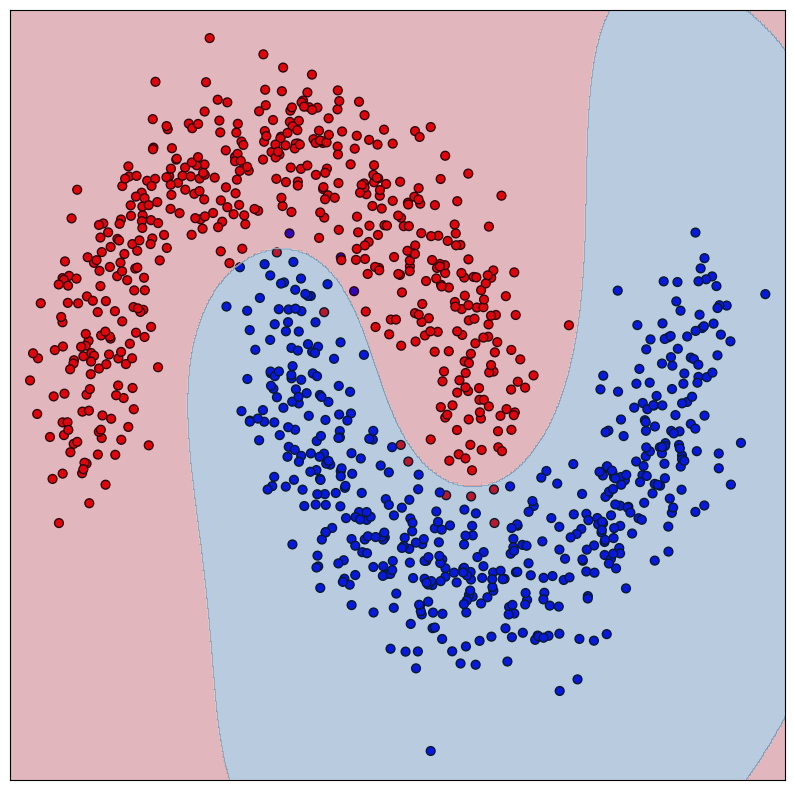

In [23]:
plot_separating_surface(X, y, svc_on_rbf_support)

### <font color='DarkOrange'>**Задание 3 [1.5 баллa]**</font>

**Сделайте вывод:** Сильно ли полученные поверхности отличаются от той, что была получена в первом задании? Что произошло с пограничными объектами? Объясните полученные результаты.

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Первый график - сдвинуты границы между кдассами, модель была обучена на всех объектах, за исключением опорных. Так как эти объекты не учитывались и произошло смещение => данные компаненты важны для обучения модели, они определяют границы. При использовании только ненадёжных опорных векторов для обучения модели SVC с ядром RBF, мы наблюдаем, что границы между классами становятся менее устойчивыми и могут не точно отражать истинные разделяющие поверхности.

Второй график - нелинейная модель из 1 части, хорошее разделение на классы.

Третий график - модель обучена на опорных объектах. График похож на второй, с довольно четкой границей.

Полученные поверхности, построенные на основе опорных объектов, отличаются от той, что была получена в первом задании, и это различие может быть значительным. 

Пограничные объекты, которые были удалены из набора данных для новой модели, часто играют критически важную роль в определении разделяющей поверхности. Эти объекты находятся на границе классов и, следовательно, имеют большое влияние на формирование модели. Когда мы исключаем их из обучения, модель может не учитывать важные аспекты структуры данных, что приводит к ухудшению качества классификации.

Таким образом, результаты показывают, что для построения надежной модели важно учитывать все опорные векторы, так как они содержат ключевую информацию о границах классов. Исключение пограничных объектов может привести к потере способности модели правильно классифицировать данные, особенно те, которые находятся близко к границе между классами.

# 4. Обучите лучшую SVM модель (ML-решение)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения.
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :)

Все csv-таблицы с данными вы можете взять из публичного теста, который также есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

In [24]:
X_train = np.load('05-SVM/public/cX_train.npy')
y_train = np.load('05-SVM/public/cy_train.npy')
X_test = np.load('05-SVM/public/cX_test.npy')

In [25]:
X_train.shape, y_train.shape, X_test.shape

((800, 5), (800,), (200, 5))

In [26]:
X = X_train
y = y_train.ravel()

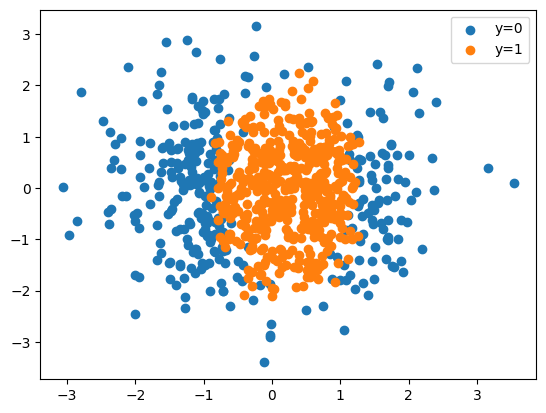

In [27]:
plt.scatter(X[y == 0, 4], X[y == 0, 3], label='y=0')
plt.scatter(X[y == 1, 4], X[y == 1, 3], label='y=1')
plt.legend()

**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном svm_solution.py. Кросс-валидацию параметров в посылаемом решении делать <font color='red'>не нужно</font> -- достаточно подобрать, например, их тут, а в решении уже обучать модель с оптимальными параметрами.**

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
svc = SVC()
parametrs_grid = {
    "C": [1, 2, 3, 4, 5, 11, 14, 18, 20],
    "gamma": [0.3, 0.5, 0.7],
    "kernel": ["linear", "rbf"]
}
grid_search = GridSearchCV(svc, parametrs_grid, cv = 5, scoring = "accuracy", n_jobs = -1)
grid_search.fit(X, y)

print("Best parametrs:", grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = accuracy_score(y, best_model.predict(X))
print(accuracy)


Best parametrs: {'C': 18, 'gamma': 0.3, 'kernel': 'rbf'}
0.98375


# Сравнение с логистической регрессией

#### <font color='DarkOrange'>**Задание 4 [1.5 баллa]**</font>

В предыдущей части Вы обучили хорошую SVM модель, подбирая гиперпараметры модели. Давайте теперь попробуем обучить логистическую регрессию на этой же выборке, и по кросс-валидации оценить влияние гиперпараметров на линейную модель.

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
# Your code here
def c_seq(n=20):
  ans = [0.1]
  for i in range(n):
    ans.append(ans[-1]*10)
  return(ans)


In [58]:
for index, C in enumerate(c_seq()):
    model = SVC(C=C, kernel='rbf')
    score = cross_val_score(model, X, y)
    print("C= ", C, " score= ", score.mean(), sep="")


C= 0.1 score= 0.8175000000000001
C= 1.0 score= 0.91375
C= 10.0 score= 0.925
C= 100.0 score= 0.9199999999999999
C= 1000.0 score= 0.8837499999999998
C= 10000.0 score= 0.8887499999999999
C= 100000.0 score= 0.8887499999999999
C= 1000000.0 score= 0.8887499999999999
C= 10000000.0 score= 0.8887499999999999
C= 100000000.0 score= 0.8887499999999999
C= 1000000000.0 score= 0.8887499999999999
C= 10000000000.0 score= 0.8887499999999999
C= 100000000000.0 score= 0.8887499999999999
C= 1000000000000.0 score= 0.8887499999999999
C= 10000000000000.0 score= 0.8887499999999999
C= 100000000000000.0 score= 0.8887499999999999
C= 1000000000000000.0 score= 0.8887499999999999
C= 1e+16 score= 0.8887499999999999
C= 1e+17 score= 0.8887499999999999
C= 1e+18 score= 0.8887499999999999
C= 1e+19 score= 0.8887499999999999


In [ ]:
for index, C in enumerate(c_seq(n=7)):
    model = SVC(C=C, kernel='poly', degree=2)
    score = cross_val_score(model, X, y)
    print("C= ", C, " score= ", score.mean(), sep="")

C= 0.1 score= 0.79875
C= 1.0 score= 0.8512500000000001
C= 10.0 score= 0.8462500000000001
C= 100.0 score= 0.8462500000000001
C= 1000.0 score= 0.8487500000000001
C= 10000.0 score= 0.8487500000000001
C= 100000.0 score= 0.8487500000000001


In [36]:
for index, C in enumerate(c_seq()):
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    score = cross_val_score(model, X, y)
    print("C= ", C, " score= ", score.mean(), sep="")

model = LogisticRegression(penalty='l1', solver='liblinear', C=1)
score = cross_val_score(model, X, y)
print("C= ", 1, " score= ", score.mean(), sep="")

C= 0.1 score= 0.8024999999999999
C= 1.0 score= 0.78625
C= 10.0 score= 0.78125
C= 100.0 score= 0.78
C= 1000.0 score= 0.78
C= 10000.0 score= 0.78
C= 100000.0 score= 0.78
C= 1000000.0 score= 0.78
C= 10000000.0 score= 0.78
C= 100000000.0 score= 0.78
C= 1000000000.0 score= 0.78
C= 10000000000.0 score= 0.78
C= 100000000000.0 score= 0.78
C= 1000000000000.0 score= 0.78
C= 10000000000000.0 score= 0.78
C= 100000000000000.0 score= 0.78
C= 1000000000000000.0 score= 0.78
C= 1e+16 score= 0.78
C= 1e+17 score= 0.78
C= 1e+18 score= 0.78
C= 1e+19 score= 0.78
C= 1 score= 0.78625


In [38]:
for i, C in enumerate(c_seq()):
    lin_model = LogisticRegression(solver='liblinear', C=C)
    score = cross_val_score(lin_model, X, y)
    print("C =", C, "score =", score.mean())

C = 0.1 score = 0.78125
C = 1.0 score = 0.78125
C = 10.0 score = 0.78
C = 100.0 score = 0.78
C = 1000.0 score = 0.78
C = 10000.0 score = 0.78
C = 100000.0 score = 0.78
C = 1000000.0 score = 0.78
C = 10000000.0 score = 0.78
C = 100000000.0 score = 0.78
C = 1000000000.0 score = 0.78
C = 10000000000.0 score = 0.78
C = 100000000000.0 score = 0.78
C = 1000000000000.0 score = 0.78
C = 10000000000000.0 score = 0.78
C = 100000000000000.0 score = 0.78
C = 1000000000000000.0 score = 0.78
C = 1e+16 score = 0.78
C = 1e+17 score = 0.78
C = 1e+18 score = 0.78
C = 1e+19 score = 0.78


In [42]:
for i, C in enumerate(c_seq()):
    lin_model = LogisticRegression(penalty='l2', solver='liblinear', C=C)
    score = cross_val_score(lin_model, X, y)
    print("C =", C, "score =", score.mean())

C = 0.1 score = 0.78125
C = 1.0 score = 0.78125
C = 10.0 score = 0.78
C = 100.0 score = 0.78
C = 1000.0 score = 0.78
C = 10000.0 score = 0.78
C = 100000.0 score = 0.78
C = 1000000.0 score = 0.78
C = 10000000.0 score = 0.78
C = 100000000.0 score = 0.78
C = 1000000000.0 score = 0.78
C = 10000000000.0 score = 0.78
C = 100000000000.0 score = 0.78
C = 1000000000000.0 score = 0.78
C = 10000000000000.0 score = 0.78
C = 100000000000000.0 score = 0.78
C = 1000000000000000.0 score = 0.78
C = 1e+16 score = 0.78
C = 1e+17 score = 0.78
C = 1e+18 score = 0.78
C = 1e+19 score = 0.78


Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Правильный выбор гиперпараметров и соответствующие преобразования выборки значительно влияют на качество обучения моделей SVM. Эксперименты с различными значениями гиперпараметров позволяют достичь высоких результатов на кросс-валидации и улучшить обобщающую способность модели.

Как видно из нашего примера, подбор гиперпараметроов практически никак не повлиял на результат линейной модели, однако на LogisticRegression(penalty='l1', solver='liblinear', C=0.1) переменная score выросла.  Для SVM подбор гиперпараметров влияет сильно, что подтверждает их важность для данной модели обучения.

### <font color='MediumSeaGreen'>**Задание 5 [1 балл][Bonus]**</font>

Найдите мем про SVM лучше чем этот:

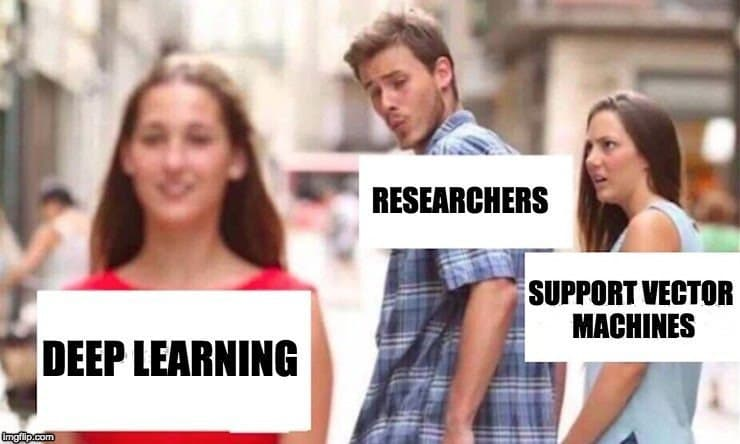

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

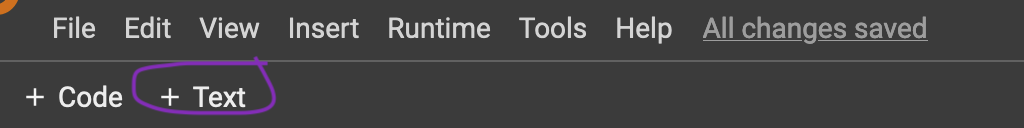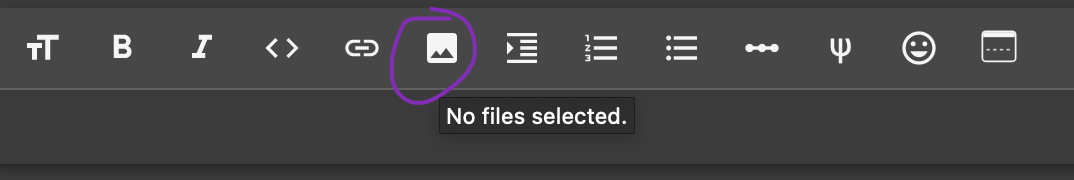

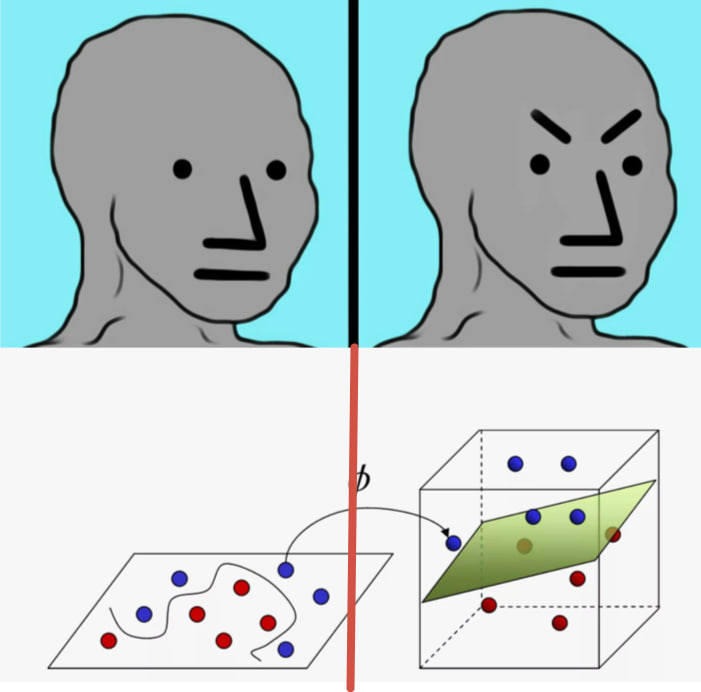